# TASK 10

VERIFIACTION of synthetic data and its accuracy (EEG Seizure Classification using CNN-LSTM with Feature Extraction)

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install PyWavelets

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import welch
import pywt

# Path to dataset folders
train_data_path = "drive/MyDrive/EEG_Data/synthetic_data"

# Labels mapping
label_mapping = {
    "Complex_Partial_Seizures": 0,
    "Electrographic_Seizures": 1,
    "Normal": 2,
    "Video_detected_Seizures_with_no_visual_change_over_EEG": 3
}

# Function to calculate time-domain features for one EEG sample
def extract_time_domain_features(eeg_data):
    features = {}
    for i, channel in enumerate(eeg_data):
        features[f'channel_{i+1}_mean'] = np.mean(channel)
        features[f'channel_{i+1}_variance'] = np.var(channel)
        features[f'channel_{i+1}_skewness'] = skew(channel)
        features[f'channel_{i+1}_kurtosis'] = kurtosis(channel)
        features[f'channel_{i+1}_zero_crossings'] = np.sum(np.diff(np.sign(channel)) != 0)
        features[f'channel_{i+1}_energy'] = np.sum(channel**2)
        features[f'channel_{i+1}_rms'] = np.sqrt(np.mean(channel**2))
    return features

# Function to calculate frequency-domain features (FFT and PSD)
def extract_frequency_domain_features(eeg_data, sampling_rate=256):
    features = {}
    for i, channel in enumerate(eeg_data):
        fft_values = np.fft.rfft(channel)
        fft_magnitude = np.abs(fft_values)

        features[f'channel_{i+1}_fft_mean'] = np.mean(fft_magnitude)
        features[f'channel_{i+1}_fft_variance'] = np.var(fft_magnitude)
        features[f'channel_{i+1}_fft_entropy'] = entropy(fft_magnitude)

        # Power Spectral Density (PSD)
        freqs, psd = welch(channel, fs=sampling_rate)
        features[f'channel_{i+1}_psd_mean'] = np.mean(psd)
        features[f'channel_{i+1}_psd_variance'] = np.var(psd)
    return features

# Function to calculate time-frequency features (Wavelet Transform)
def extract_wavelet_features(eeg_data, wavelet='db4', level=4):
    features = {}
    for i, channel in enumerate(eeg_data):
        coeffs = pywt.wavedec(channel, wavelet, level=level)
        for j, coeff in enumerate(coeffs):
            features[f'channel_{i+1}_wavelet_level_{j}_mean'] = np.mean(coeff)
            features[f'channel_{i+1}_wavelet_level_{j}_energy'] = np.sum(coeff**2)
    return features

# Function to calculate entropy-based features
def extract_entropy_features(eeg_data):
    features = {}
    for i, channel in enumerate(eeg_data):
        features[f'channel_{i+1}_shannon_entropy'] = entropy(np.histogram(channel, bins=10)[0])
    return features

# Function to process a dataset folder and extract features
def process_dataset(folder_path, label_mapping):
    all_features = []
    for label_folder in os.listdir(folder_path):  # Loop through label folders
        if label_folder in label_mapping:
            label = label_mapping[label_folder]
            folder_full_path = os.path.join(folder_path, label_folder)
            for file_name in os.listdir(folder_full_path):
                file_path = os.path.join(folder_full_path, file_name)
                eeg_data = np.load(file_path)  # Load EEG data (shape: channels x timepoints)

                # Extract features
                time_features = extract_time_domain_features(eeg_data)
                freq_features = extract_frequency_domain_features(eeg_data)
                wavelet_features = extract_wavelet_features(eeg_data)
                entropy_features = extract_entropy_features(eeg_data)

                # Combine all features
                features = {**time_features, **freq_features, **wavelet_features, **entropy_features}
                features['label'] = label
                features['file_name'] = file_name

                all_features.append(features)
    return pd.DataFrame(all_features)

# Process train and validation datasets
train_features = process_dataset(train_data_path, label_mapping)

# Save extracted features
train_features.to_csv("test_all_features.csv", index=False)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Load extracted features
train_features = pd.read_csv("test_all_features.csv")

# Separate features and labels
X = train_features.drop(columns=["label", "file_name"])  # Drop non-feature columns
y = train_features["label"]


features_to_drop = {'channel_18_energy', 'channel_4_energy', 'channel_1_wavelet_level_4_energy', 'channel_17_energy', 'channel_14_wavelet_level_0_energy', 'channel_17_fft_mean', 'channel_13_wavelet_level_0_energy', 'channel_2_wavelet_level_4_energy', 'channel_17_rms', 'channel_1_wavelet_level_0_energy', 'channel_19_fft_variance', 'channel_8_fft_variance', 'channel_5_wavelet_level_4_energy', 'channel_3_fft_mean', 'channel_19_wavelet_level_4_energy', 'channel_2_wavelet_level_0_energy', 'channel_1_fft_variance', 'channel_18_wavelet_level_4_energy', 'channel_6_wavelet_level_4_energy', 'channel_7_fft_mean', 'channel_15_rms', 'channel_11_energy', 'channel_17_wavelet_level_0_energy', 'channel_4_rms', 'channel_10_wavelet_level_0_energy', 'channel_15_wavelet_level_0_energy', 'channel_4_fft_mean', 'channel_18_fft_mean', 'channel_8_psd_variance', 'channel_5_fft_mean', 'channel_5_rms', 'channel_1_fft_mean', 'channel_9_wavelet_level_3_energy', 'channel_2_fft_mean', 'channel_5_wavelet_level_0_energy', 'channel_14_wavelet_level_3_energy', 'channel_7_energy', 'channel_6_wavelet_level_0_energy', 'channel_14_fft_mean', 'channel_6_energy', 'channel_2_energy', 'channel_7_rms', 'channel_7_fft_variance', 'channel_6_wavelet_level_3_energy', 'channel_11_fft_mean', 'channel_4_fft_variance', 'channel_3_rms', 'channel_10_fft_mean', 'channel_9_wavelet_level_4_energy', 'channel_13_psd_variance', 'channel_8_fft_mean', 'channel_5_fft_variance', 'channel_18_fft_variance', 'channel_16_energy', 'channel_18_psd_mean', 'channel_15_wavelet_level_4_energy', 'channel_3_fft_variance', 'channel_3_wavelet_level_0_energy', 'channel_7_wavelet_level_4_energy', 'channel_12_rms', 'channel_13_fft_variance', 'channel_8_wavelet_level_4_energy', 'channel_7_wavelet_level_3_energy', 'channel_15_fft_variance', 'channel_2_wavelet_level_3_energy', 'channel_19_energy', 'channel_12_fft_variance', 'channel_9_fft_mean', 'channel_12_wavelet_level_0_energy', 'channel_18_wavelet_level_0_energy', 'channel_19_fft_mean', 'channel_10_energy', 'channel_15_energy', 'channel_9_rms', 'channel_11_fft_variance', 'channel_16_fft_variance', 'channel_13_wavelet_level_4_energy', 'channel_9_energy', 'channel_13_wavelet_level_3_energy', 'channel_11_wavelet_level_0_energy', 'channel_6_fft_variance', 'channel_11_rms', 'channel_10_psd_mean', 'channel_15_psd_mean', 'channel_14_fft_variance', 'channel_3_wavelet_level_4_energy', 'channel_7_wavelet_level_0_energy', 'channel_9_wavelet_level_0_energy', 'channel_9_variance', 'channel_4_wavelet_level_0_energy', 'channel_10_fft_variance', 'channel_15_fft_mean', 'channel_10_wavelet_level_4_energy', 'channel_5_energy', 'channel_3_psd_mean', 'channel_2_fft_variance', 'channel_17_fft_variance', 'channel_6_fft_mean', 'channel_10_rms', 'channel_16_psd_mean', 'channel_14_wavelet_level_4_energy', 'channel_7_psd_mean', 'channel_14_energy', 'channel_1_energy', 'channel_1_wavelet_level_3_energy', 'channel_13_energy', 'channel_8_energy', 'channel_16_fft_mean', 'channel_5_psd_mean', 'channel_18_rms', 'channel_13_psd_mean', 'channel_9_psd_mean', 'channel_12_fft_mean', 'channel_3_energy', 'channel_19_wavelet_level_0_energy', 'channel_12_energy', 'channel_16_wavelet_level_0_energy', 'channel_9_fft_variance'}


# Drop the features
X_uncorrelated = X.drop(columns=features_to_drop)


In [ ]:


# Combine the selected common features with the label
selected_features_df = X_uncorrelated
selected_features_df["label"] = y

# Save the resulting dataset
selected_features_df.to_csv("train_selected_features.csv", index=False)
print("Feature selection complete. Saved to 'train_selected_features.csv'.")


Feature selection complete. Saved to 'train_selected_features.csv'.



44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       549
           1       0.88      0.75      0.81       137
           2       0.82      0.85      0.84       696
           3       0.95      0.78      0.86        21

    accuracy                           0.83      1403
   macro avg       0.86      0.80      0.83      1403
weighted avg       0.83      0.83      0.83      1403

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
ROC-AUC Score: 0.9518230847190025



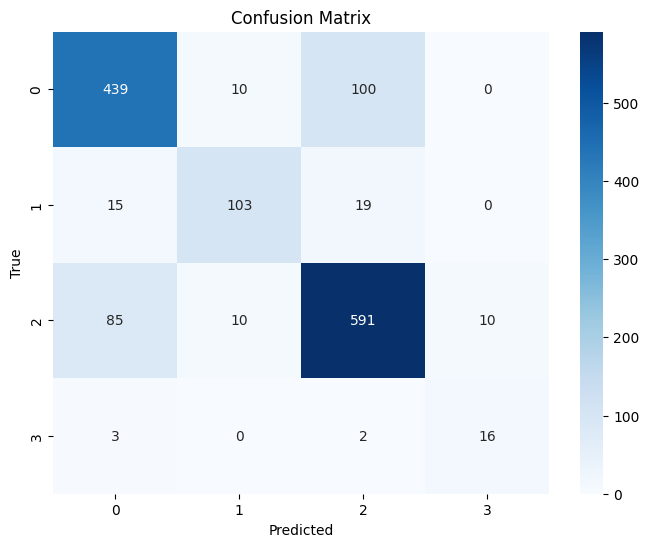

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
train_features = pd.read_csv("train_selected_features.csv")
validation_features = pd.read_csv("validate_selected_features.csv")  # Full validation set

# Prepare data
X_train = train_features.drop(columns=["label"])
y_train = train_features["label"]

X_val = validation_features.drop(columns=["label"])
y_val = validation_features["label"]

# Normalize the features
X_train = (X_train - X_train.mean()) / X_train.std()
X_val = (X_val - X_val.mean()) / X_val.std()

# Reshape for CNN-LSTM (samples, time-steps, features)
X_train = np.expand_dims(X_train.values, axis=2)  # Shape: (samples, time-steps, 1)
X_val = np.expand_dims(X_val.values, axis=2)

# Convert labels to one-hot encoding
num_classes = len(np.unique(y_train))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

# Load the best model from Bayesian Optimization (assuming 'best_model' is the best model returned by tuner)
best_model = tf.keras.models.load_model("optimized_cnn_lstm_model.h5")

# Evaluate the model
y_pred = np.argmax(best_model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# ROC-AUC Score (One-vs-Rest)
roc_auc = roc_auc_score(y_val, best_model.predict(X_val), multi_class="ovr")
print(f"ROC-AUC Score: {roc_auc}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
